In [24]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns', None)

In [25]:
pet_df = pd.read_csv("../data/train/train.csv") #Beware of directory
test_df = pd.read_csv("../data/test/test.csv") 

In [26]:
def featurize_table(tabular_df):
    # Namelength
    tabular_df["name_length"] = tabular_df['Name'].str.len().fillna(0)
    
    # Description length
    tabular_df['description_length'] = tabular_df['Description'].str.len().fillna(0)
    
    # Drop unused columns
    tabular_df.drop(['Name', 'PetID', 'RescuerID', 'Description'], axis=1, inplace=True)
    return tabular_df

#categorical_features = 
#numerical_features = 
pet_features = featurize_table(pet_df)
test_features = featurize_table(test_df)
pet_features.head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,name_length,description_length
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,0,1.0,2,6.0,359.0
1,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,0,2.0,0,11.0,118.0
2,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,0,7.0,3,6.0,393.0
3,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,0,8.0,2,4.0,146.0
4,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,0,3.0,2,6.0,390.0


In [27]:
from sklearn.model_selection import train_test_split
X = pet_features.drop(['AdoptionSpeed'], axis=1)
y = pet_features['AdoptionSpeed'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
prediction_dummy = dummy_clf.predict(X_test)

In [29]:
# XGBoost (Basic)
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    objective='clf:accuracy',
    n_estimators = 100,
    learning_rate=0.1,
    max_depth=2,
    #early_stopping_rounds=50, # Use early stoppage to mitigate overfitting
    n_jobs=-1 # enables parallel on all cores for faster training
)

xgb_clf.fit(X_train, y_train)
prediction_xgb = xgb_clf.predict(X_test)


In [ ]:
# XGBoost (Tuned)
import xgboost as xgb


In [33]:
from sklearn.metrics import cohen_kappa_score, accuracy_score

def evaluate_model(model_name: str, model_prediction):
    print(f"Model: {model_name}")
    print(f"Kappa Score: {cohen_kappa_score(model_prediction, y_test, weights='quadratic')}")
    print(f"Accuracy Score: {accuracy_score(model_prediction, y_test)}")
    print("\n")


evaluate_model(dummy_clf.__class__.__name__, prediction_dummy)
evaluate_model(xgb_clf.__class__.__name__, prediction_xgb)

Model: DummyClassifier
Kappa Score: 0.0
Accuracy Score: 0.27775925308436145


Model: XGBClassifier
Kappa Score: 0.3606412696106618
Accuracy Score: 0.40746915638546183




<Figure size 1200x600 with 0 Axes>

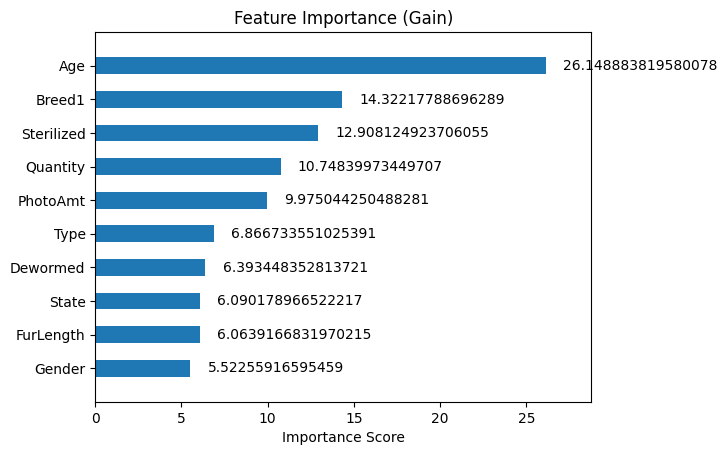

In [36]:
# Feature Importance: which factors benefit the prediction the most (extracted from XGBoost)
# ensure usage of original feature names not just np array indices
xgb_clf.get_booster().feature_names = list(X.columns)

plt.figure(figsize=(12,6))
xgb.plot_importance(xgb_clf, max_num_features=10, height=0.5, importance_type="gain") # Weight ใช้อะไรมากที่สุดเป็นส่วนประกอบ tree, Gain อะไรแบ่งได้มากสุด
plt.title("Feature Importance (Gain)")
plt.xlabel("Importance Score")
plt.ylabel("")
plt.grid(False)
plt.show()